In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
sys.path.append('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code/Experiment/Evaluation')
from Evaluation import *
import jieba
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import logging
from gensim.test.utils import get_tmpfile
from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE
from scipy.stats import ks_2samp
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [13]:
colors={
    'all':'#c24e3d',
    'weak':'#7b5347',
    'neutral':'#35180e',
    'strong':'#cb8d79',
#     'InfoLevel4':'#fad4ca',
}

labels={
    'all':'全部政策',
    'weak':'弱情绪政策',
    'neutral':'中情绪政策',
    'strong':'强情绪政策',
#     'InfoLevel4':'四级政策',
}

In [2]:
evaluator = Evaluation()
evaluator.PortfolioAnalysis(labels=evaluator.factorNameList, n=3, excess_ret='月收益率_Monret', date='datetime64', weights=['月总市值(元)_Monmc'])

def preprocess_MSVARresult(path:str):
    res = (pd.read_csv(path)
               .assign(separation=lambda x: x[['colMeans.states.']].applymap(lambda x: round(x)))
               .assign(index= lambda x: concat_year_and_month(x))
               .pipe(lambda x: x[['separation','index']])
               .set_index('index')
               .rename(columns={'separation':'0'})
               )
    return res

正在使用Resset数据...Resset数据加载完成。时间：0.6727800369262695


遍历每个股票求解因子载荷: 100%|██████████| 4996/4996 [02:38<00:00, 31.55it/s]


## 寻找状态对应的重点事件

In [66]:
# all 状态
state_all = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(all)_20240329_cutted.csv')
evaluator.addResult(state_all)
state_all = evaluator.PAresult['separation']

# weak 状态
state_weak = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(weak)_20240329_cutted.csv')
evaluator.addResult(state_weak)
state_weak = evaluator.PAresult['separation']

# neutral 状态
state_neutral = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(neutral)_20240329_cutted.csv')
evaluator.addResult(state_neutral)
state_neutral = evaluator.PAresult['separation']

# strong 状态
state_strong = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(strong)_20240329_cutted.csv')
evaluator.addResult(state_strong)
state_strong = evaluator.PAresult['separation']

states = pd.concat(
    {
        'all':state_all,
        'weak':state_weak,
        'neutral':state_neutral,
        'strong':state_strong,
#         'InfoLevel4':state_InfoLevel4,
    },
    axis=1
)
states = (
    states.dropna()
    .reset_index()
    .assign(Year=lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month=lambda x: x[['datetime64']].applymap(lambda y: y.month))
)
display(states.head())
display(states.tail())

,datetime64,all,weak,neutral,strong,Year,Month
0,2005-03-31,1.0,1.0,1.0,1.0,2005,3
1,2005-04-30,1.0,1.0,1.0,1.0,2005,4
2,2005-05-31,1.0,1.0,1.0,1.0,2005,5
3,2005-06-30,1.0,1.0,1.0,1.0,2005,6
4,2005-07-31,1.0,1.0,1.0,1.0,2005,7


,datetime64,all,weak,neutral,strong,Year,Month
214,2023-01-31,1.0,1.0,1.0,1.0,2023,1
215,2023-02-28,1.0,1.0,1.0,1.0,2023,2
216,2023-03-31,1.0,1.0,1.0,1.0,2023,3
217,2023-04-30,1.0,1.0,1.0,1.0,2023,4
218,2023-05-31,1.0,1.0,1.0,1.0,2023,5


/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_77450/2471104531.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(41*10+i+1)


Text(0.5, 0, '事件')

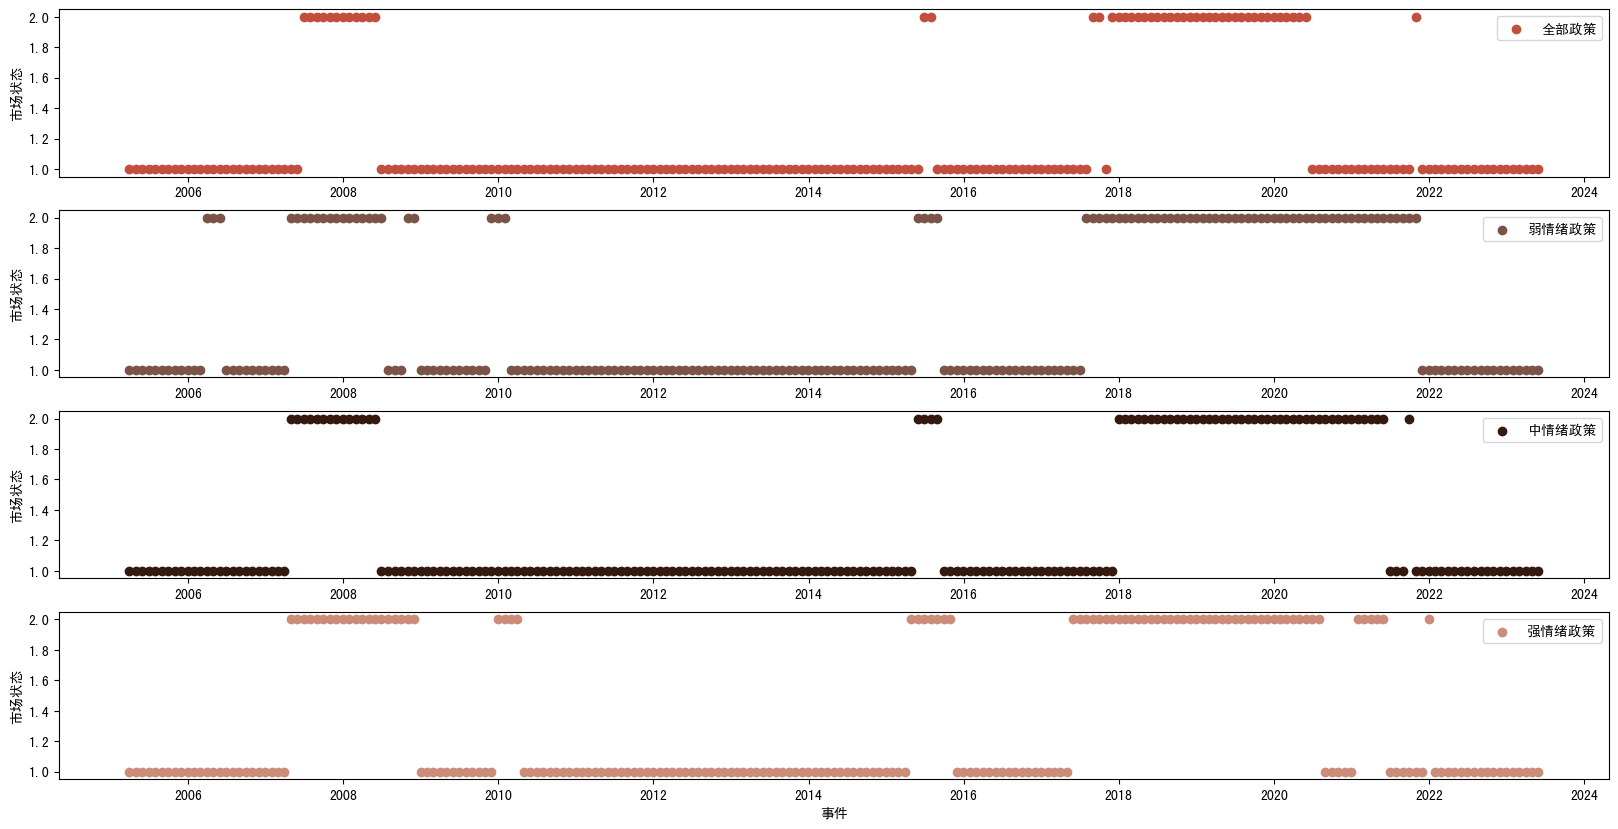

In [67]:
colors={
    'all':'#c24e3d',
    'weak':'#7b5347',
    'neutral':'#35180e',
    'strong':'#cb8d79',
#     'InfoLevel4':'#fad4ca',
}

labels={
    'all':'全部政策',
    'weak':'弱情绪政策',
    'neutral':'中情绪政策',
    'strong':'强情绪政策',
#     'InfoLevel4':'四级政策',
}

fig, ax = plt.subplots(5,1, figsize=(20,10), sharex=True)


for i,value in enumerate(['all','weak','neutral','strong']):
    plt.subplot(41*10+i+1)
    plt.scatter(states['datetime64'], states[value], color=colors[value],label=labels[value])
    plt.legend()
    plt.ylabel('市场状态')
plt.xlabel('事件')

In [68]:
def tokenize_and_del_stopword(stopword_set, text: pd.Series):
    raw_texts = text.to_list()
    res = []
    for raw_text in tqdm(raw_texts):
        tokenized_text = jieba.lcut_for_search(raw_text)
        temp = []
        for word in tokenized_text:
            if not word in stopword_set:
                temp.append(word)
        res.append(temp)
    return res

stopwords = []
with open("/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/baidu_stopwords.txt", "r") as f:
    for line in f.readlines():
        line = line.strip('\n')  # 去掉列表中每一个元素的换行符
        stopwords.append(line)
stopwords = set(stopwords)

Industry_policy = (
    pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/行业政策/ED_IndustryPolicy.csv')
    .pipe(lambda x: pd.merge(pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/RESSET_INDPOLICY_1.csv'), x, left_on='观测ID()_ID', right_on='ID'))
    .assign(InfoPublDateNP=lambda x: x[['InfoPublDate']].applymap(lambda x: np.datetime64(x)))
    .assign(TokenContent=lambda x: tokenize_and_del_stopword(stopwords, x['Content']))
    )

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(Industry_policy['TokenContent'])]
# model = Doc2Vec(documents, vector_size=10, window=4, min_count=1, workers=4)
fname = get_tmpfile("/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model")
# model.save(fname)
model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

# 计算每一个doc的向量
temp_doc = []
for doc in tqdm(Industry_policy['TokenContent'], desc='计算doc对应的向量'):
    temp_doc.append(model.infer_vector(doc))

Industry_policy = (
    Industry_policy
    .assign(DocVec = temp_doc)
    .assign(InfoPublYear = lambda x: x[['InfoPublDateNP']].applymap(lambda x: x.year))
    .assign(InfoPublMon = lambda x: x[['InfoPublDateNP']].applymap(lambda x: x.month))
    .assign(DocVec = temp_doc)
    .pipe(lambda x: x.loc[x['信息级别_InfoLevel']<=3])
    )
Industry_policy.head(1)

100%|██████████| 22497/22497 [00:37<00:00, 607.23it/s]
2024-03-29 13:01:53,727 : INFO : loading Doc2Vec object from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model
2024-03-29 13:01:53,758 : INFO : loading dv recursively from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model.dv.* with mmap=None
2024-03-29 13:01:53,759 : INFO : loading wv recursively from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model.wv.* with mmap=None
2024-03-29 13:01:53,759 : INFO : setting ignored attribute cum_table to None
2024-03-29 13:01:54,173 : INFO : Doc2Vec lifecycle event {'fname': '/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model', 'datetime': '2024-03-29T13:01:54.173220', 'gensim': '4.3.0', 'python': '3.10.12 (main, Jul  5 2023, 15:02:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'loaded'}
计算doc对应的向量: 100%

,观测ID()_ID,事件标志_EventFlg,信息发布日期_InfoPubDt,媒体出处代码()_MediaCd,媒体出处_Media,撰写机构_Writer,作者_Author,信息内容_Content,信息对象代码()_ObjCd,信息地域划分代码()_RegionCd,...,MediaCode,Writer,Author,InfoTitle,Content,InfoPublDateNP,TokenContent,DocVec,InfoPublYear,InfoPublMon
0,670676730611,1,2021-04-02,3,上海证券报,NaN,NaN,NaN,1000,142.0,...,3,NaN,NaN,权益变动信息 披露知多少,小费阿姨：小钟老师，近期我关注的上市公司发布了临时公告，是关于大股东持有公司权益变动...,2021-04-02,"[小费, 阿姨, 小钟, 老师, 近期, 关注, 上市, 公司, 上市公司, 发布, 临时,...","[1.7899244, -0.9994793, -0.9295504, 0.27107427...",2021,4


In [69]:
print(Industry_policy.columns)
# Industry_policy.loc[(Industry_policy['InfoPublYear']==2008) & (Industry_policy['InfoPublMon']==12)]

Index(['观测ID()_ID', '事件标志_EventFlg', '信息发布日期_InfoPubDt', '媒体出处代码()_MediaCd',
       '媒体出处_Media', '撰写机构_Writer', '作者_Author', '信息内容_Content',
       '信息对象代码()_ObjCd', '信息地域划分代码()_RegionCd', '涉及机构编码_InvInsCd',
       '涉及机构名称_InvInsNm', '信息级别_InfoLevel', '省市编码_ProvNum', '省市名称_Prov',
       '行业编码_IndNum', '行业板块_IndPla', '行业代码_IndCd', '行业名称_IndNm', '记录时间_RecDt',
       'Unnamed: 20', 'ID', 'InfoPublDate', 'Media', 'MediaCode', 'Writer',
       'Author', 'InfoTitle', 'Content', 'InfoPublDateNP', 'TokenContent',
       'DocVec', 'InfoPublYear', 'InfoPublMon'],
      dtype='object')


In [70]:
policy_and_states = pd.merge(states, Industry_policy, left_on=['Year','Month'], right_on=['InfoPublYear','InfoPublMon'])
print(policy_and_states.columns,end='\n')
print(len(policy_and_states))

Index(['datetime64', 'all', 'weak', 'neutral', 'strong', 'Year', 'Month',
       '观测ID()_ID', '事件标志_EventFlg', '信息发布日期_InfoPubDt', '媒体出处代码()_MediaCd',
       '媒体出处_Media', '撰写机构_Writer', '作者_Author', '信息内容_Content',
       '信息对象代码()_ObjCd', '信息地域划分代码()_RegionCd', '涉及机构编码_InvInsCd',
       '涉及机构名称_InvInsNm', '信息级别_InfoLevel', '省市编码_ProvNum', '省市名称_Prov',
       '行业编码_IndNum', '行业板块_IndPla', '行业代码_IndCd', '行业名称_IndNm', '记录时间_RecDt',
       'Unnamed: 20', 'ID', 'InfoPublDate', 'Media', 'MediaCode', 'Writer',
       'Author', 'InfoTitle', 'Content', 'InfoPublDateNP', 'TokenContent',
       'DocVec', 'InfoPublYear', 'InfoPublMon'],
      dtype='object')
19339


In [71]:
print(policy_and_states[['datetime64']].sort_values(by='datetime64').iloc[0])
print(policy_and_states[['datetime64']].sort_values(by='datetime64').iloc[-1])

datetime64   2005-03-31
Name: 0, dtype: datetime64[ns]
datetime64   2023-05-31
Name: 19338, dtype: datetime64[ns]


### 直观分析行业是否受到影响
使用“信息级别”识别出来的市场状态是否能影响各个行业？
1. 通过不同状态的行业收益率的散点图看出:
    1. 不同状态的收益率方差存在差异
    2. 市场状态转换附近的收益率方差比状态中间的方差更小
        例如，以下行业和信息级别较为明显：
        ```
        ind = 'M'; state='InfoLevel1'
        ind = 'M'; state='InfoLevel4'
        ind = 'N'; state='InfoLevel4'
        ind = 'E'; state='general'
        , and so forth....
        ```
2. 检验信息级别对于全行业是否有影响：
    
   方法：固定信息级别，按照状态1和状态2把各行业的收益率方差分组，使用KS检验方差分布
   
   结果：InfoLevel1和InfoLevel3的政策文本识别出来的市场状态的分布差异明显

3. 检验在市场状态切换时，波动率是否有明显降低
   
   方法：使用日度数据计算各个行业的波动率，观察状态转换前后的波动率的平均值
   
   结果：发现在市场状态转换的时候，波动率明显下降；在转换之前和之后波动率更高。

In [72]:
industry_return = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/行业月收益率_流通市值加权.csv',usecols=[0,1,2])
                   .assign(Date_np = lambda x: x[['日期_Date']].applymap(lambda x: np.datetime64(x)))
                   .assign(Year = lambda x: x[['Date_np']].applymap(lambda x: x.year))
                   .assign(Month = lambda x: x[['Date_np']].applymap(lambda x: x.month))
                  )
industry_return = industry_return.pivot(index=['Year','Month'],columns='证监会行业门类代码_Csrciccd1',values='行业月收益率_流通市值加权_Mrettmv').reset_index()
indret_and_states = pd.merge(industry_return, states, left_on=['Year','Month'], right_on=['Year','Month'])
indret_and_states.head()

,Year,Month,A,B,C,D,E,F,G,H,...,O,P,Q,R,S,datetime64,all,weak,neutral,strong
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,-0.2075,NaN,NaN,-0.1380,-0.1432,2005-03-31,1.0,1.0,1.0,1.0
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,-0.0702,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,1.0
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,-0.0188,NaN,NaN,0.0376,-0.0265,2005-05-31,1.0,1.0,1.0,1.0
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.0173,NaN,NaN,0.0172,-0.0175,2005-06-30,1.0,1.0,1.0,1.0
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,-0.1237,NaN,NaN,-0.1235,-0.0571,2005-07-31,1.0,1.0,1.0,1.0


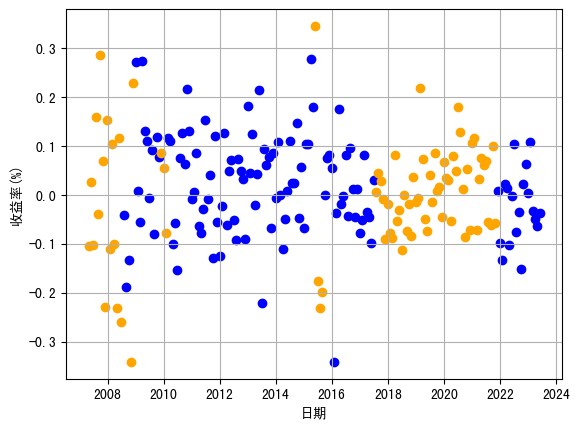

In [73]:
ind = 'M'; state='weak'
# ind = 'M'; state='InfoLevel4'
# ind = 'N'; state='InfoLevel4'
# ind = 'E'; state='general'
fig, ax = plt.subplots()
colors = ['blue','orange']
for i in range(len(indret_and_states)):
    ax.scatter(indret_and_states['datetime64'][i], indret_and_states[ind][i], 
               color=colors[int(indret_and_states[state][i]-1)], 
               alpha=1)
# ax.set_title("不同市场状态下收益率散点图\n（行业={}, 信息级别={}）".format(ind, state[-1]))
ax.set_xlabel("日期")
ax.set_ylabel('收益率(%)')
ax.grid(True)
plt.savefig('/Users/yanyan/Downloads/图片/不同市场状态下收益率散点图_ind{}_{}'.format(ind,state),dpi=350)
plt.show()

In [75]:
# state_1 = []; state_2=[]
# # for state in ['InfoLevel1', 'InfoLevel2', 'InfoLevel3', 'InfoLevel4']:
# for state in ['general', 'InfoLevel1']:
#     for ind in list("BMLQOE"):
#         state_1.append(indret_and_states.groupby(state)[ind].std().values[0])
#         state_2.append(indret_and_states.groupby(state)[ind].std().values[1])
# print(ks_2samp(state_1, state_2))
# print("MEAN of state 1={}, MEAN of state 2={}".format(np.round(np.mean(state_1),4), np.round(np.mean(state_2),4)))
# print("STD of state 1={}, STD of state 2={},".format(np.round(np.std(state_1),4), np.round(np.std(state_2),4)))
# # print(np.mean(state_1), np.mean(state_2))
# # print(np.std(state_1), np.std(state_2))

In [76]:
for state in ['all','weak','neutral','strong']:
    state_1 = []; state_2=[]
    for ind in industry_return.columns[2:]:
        state_1.append(indret_and_states.groupby(state)[ind].std().values[0])
        state_2.append(indret_and_states.groupby(state)[ind].std().values[1])
    print("state: {}".format(state))
    print(ks_2samp(state_1, state_2))
    print("MEAN of state 1={}, MEAN of state 2={}".format(np.round(np.mean(state_1),4), np.round(np.mean(state_2),4)))
    print("STD of state 1={}, STD of state 2={},".format(np.round(np.std(state_1),4), np.round(np.std(state_2),4)))
    print()

state: all
KstestResult(statistic=0.3157894736842105, pvalue=0.3056890512159651, statistic_location=0.09683871047587946, statistic_sign=-1)
MEAN of state 1=0.1049, MEAN of state 2=0.0967
STD of state 1=0.0217, STD of state 2=0.017,

state: weak
KstestResult(statistic=0.5789473684210527, pvalue=0.002767187834654101, statistic_location=0.09726281851968205, statistic_sign=1)
MEAN of state 1=0.0971, MEAN of state 2=0.113
STD of state 1=0.0226, STD of state 2=0.0203,

state: neutral
KstestResult(statistic=0.47368421052631576, pvalue=0.026749480251438945, statistic_location=0.0987848190466473, statistic_sign=1)
MEAN of state 1=0.1005, MEAN of state 2=0.1103
STD of state 1=0.0206, STD of state 2=0.0228,

state: strong
KstestResult(statistic=0.7368421052631579, pvalue=2.8402221176801622e-05, statistic_location=0.10569466632666219, statistic_sign=1)
MEAN of state 1=0.0941, MEAN of state 2=0.118
STD of state 1=0.0219, STD of state 2=0.0223,



,Year,Month,A,B,C,D,E,F,G,H,...,J_Var,K_Var,L_Var,M_Var,N_Var,O_Var,P_Var,Q_Var,R_Var,S_Var
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,0.000162,0.000156,0.000110,NaN,0.000130,0.000531,NaN,NaN,0.000702,0.000173
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,0.000438,0.000289,0.000221,NaN,0.000194,0.000712,NaN,NaN,0.001199,0.000485
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,0.000201,0.000300,0.000204,NaN,0.000088,0.000353,NaN,NaN,0.000548,0.000168
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.000559,0.000547,0.000566,NaN,0.000477,0.000528,NaN,NaN,0.000989,0.000562
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,0.000320,0.000469,0.000291,NaN,0.000294,0.000855,NaN,NaN,0.001450,0.000391


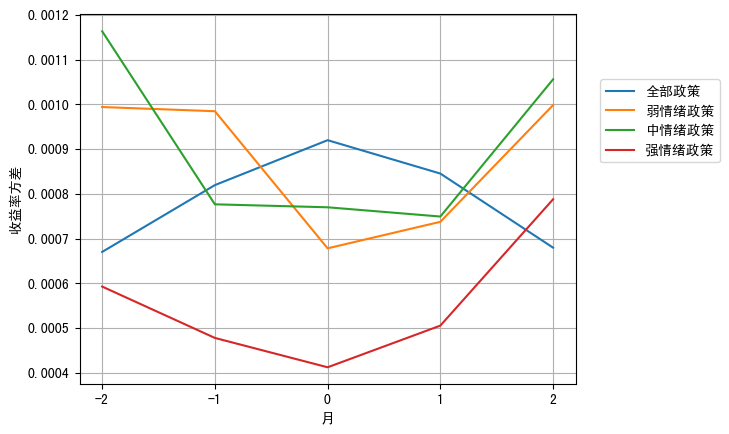

In [106]:
temp = (pd.concat([pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/证监会门类行业日收益率/RESSET_DRET_INDUSTRY_1_1.csv'), 
                  pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/证监会门类行业日收益率/RESSET_DRET_INDUSTRY_1_2.csv')],
                  axis=0
                 )
        .assign(datetime64 = lambda x: x[['日期_Date']].applymap(lambda x: np.datetime64(x)))
        .set_index('datetime64')
        .pipe(lambda x: x.groupby('证监会行业门类代码_Csrciccd1')['行业日收益率_流通市值加权_Drettmv'].resample('M').var())
        .reset_index()
        .pivot_table(index='datetime64',columns='证监会行业门类代码_Csrciccd1',values='行业日收益率_流通市值加权_Drettmv')
       )
temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64', suffixes=['','_Var'])
display(temp.head())

var = temp[['datetime64','A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']]

fig, ax = plt.subplots()
n=2
for state in ['all','weak','neutral','strong']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
        for ind in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S']:
#         for ind in ['P']:
#         for ind in ['N']:
            ind = ind + '_Var'
            current.append(temp[ind].iloc[i])
            if i-2 >= 0: before_2.append(temp[ind].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp[ind].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp[ind].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp[ind].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
#     labels={
#         'general':'全部',
#         'InfoLevel1':'一级政策',
#         'InfoLevel2':'二级政策',
#         'InfoLevel3':'三级政策',
# #         'InfoLevel4':'四级政策',
#     }
#     colors={
#         'general':'#c24e3d',
#         'InfoLevel1':'#7b5347',
#         'InfoLevel2':'#35180e',
#         'InfoLevel3':'#cb8d79',
# #         'InfoLevel4':'#fad4ca',
#     }
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_ylabel('收益率方差')
ax.set_xlabel('月')
# ax.set_title('状态转换附近5月的收益率方差')
ax.grid(True)
plt.savefig('/Users/yanyan/Downloads/图片/状态转换附近5月的收益率方差', dpi=350)
plt.show()

<Axes: xlabel='datetime64'>

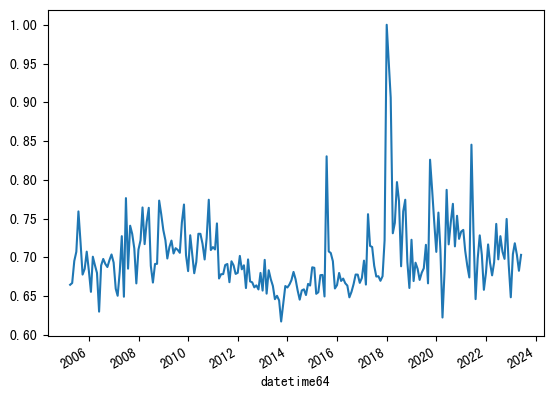

In [79]:
def get_concentration(arr):
    std_arr = []
    for x in arr:
        std_arr.append(x / np.linalg.norm(x))
    sum_arr = np.sum(np.array(std_arr), axis=0) / len(std_arr)
    return np.linalg.norm(sum_arr)
(policy_and_states.groupby('datetime64')['DocVec'].apply(lambda x: get_concentration(x.values))).plot()

,Year,Month,A,B,C,D,E,F,G,H,...,P,Q,R,S,datetime64,all,weak,neutral,strong,concentration
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,NaN,NaN,-0.1380,-0.1432,2005-03-31,1.0,1.0,1.0,1.0,0.723415
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,1.0,0.728553
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,NaN,NaN,0.0376,-0.0265,2005-05-31,1.0,1.0,1.0,1.0,0.756067
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,NaN,NaN,0.0172,-0.0175,2005-06-30,1.0,1.0,1.0,1.0,0.770272
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,NaN,NaN,-0.1235,-0.0571,2005-07-31,1.0,1.0,1.0,1.0,0.792813


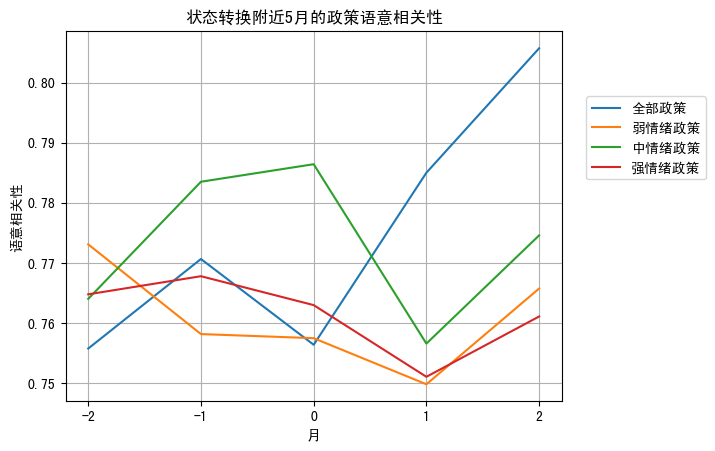

In [81]:
def recursive_corr(arr):
    corr_list = []
    for i in range(len(arr)):
        for j in range(i,len(arr)):
            corr_list.append(np.corrcoef(arr[i],arr[j]))
    return np.mean(corr_list)

temp = (pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].apply(lambda x: recursive_corr(x.values)))
        .rename(columns={'DocVec':'concentration'})
       )

temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64')

concentration = temp
display(temp.head())
fig, ax = plt.subplots()
for state in ['all','weak','neutral','strong']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
            current.append(temp['concentration'].iloc[i])
            if i-2 >= 0: before_2.append(temp['concentration'].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp['concentration'].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp['concentration'].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp['concentration'].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_title('状态转换附近5月的政策语意相关性')
ax.set_xlabel('月')
ax.set_ylabel('语意相关性')
ax.grid(True)
plt.show()

,Year,Month,A,B,C,D,E,F,G,H,...,P,Q,R,S,datetime64,all,weak,neutral,strong,concentration
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,NaN,NaN,-0.1380,-0.1432,2005-03-31,1.0,1.0,1.0,1.0,106
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,1.0,131
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,NaN,NaN,0.0376,-0.0265,2005-05-31,1.0,1.0,1.0,1.0,106
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,NaN,NaN,0.0172,-0.0175,2005-06-30,1.0,1.0,1.0,1.0,75
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,NaN,NaN,-0.1235,-0.0571,2005-07-31,1.0,1.0,1.0,1.0,89


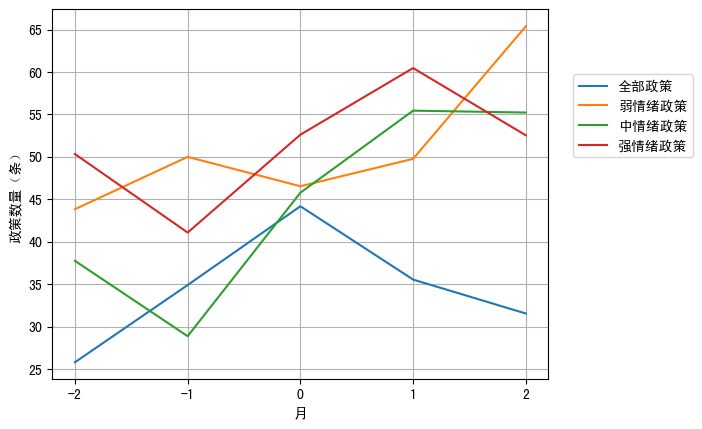

In [83]:
temp = (pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count())
        .rename(columns={'DocVec':'concentration'})
       )

temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64')
display(temp.head())

num = {}

fig, ax = plt.subplots()
for state in ['all','weak','neutral','strong']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
            current.append(temp['concentration'].iloc[i])
            if i-2 >= 0: before_2.append(temp['concentration'].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp['concentration'].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp['concentration'].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp['concentration'].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
#     print(state, '\t', y)
#     if state=='general': print((diff.loc[diff[state]!=0]).index)
#     if state=='InfoLevel1': print((diff.loc[diff[state]!=0]).index)
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
# ax.set_title('状态转换附近5月的政策数量')
ax.set_xlabel('月')
ax.set_ylabel('政策数量（条）')
ax.grid(True)
plt.savefig('/Users/yanyan/Downloads/图片/状态转换附近5月的政策数量.png',dpi=250)
plt.show()

#### 检查不同的市场状态下的向量的距离

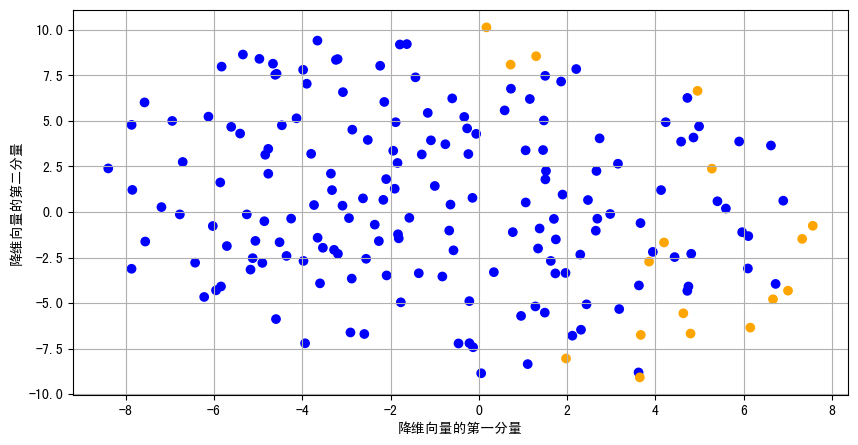

In [22]:
# 降维散点图

from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE

def scatter_dimension_reduced(start, end, state):
    temp = pd.merge(policy_and_states.groupby(['Year','Month'])['DocVec'].mean().reset_index(),
         states,
         left_on=['Year','Month'],
         right_on=['Year','Month']
        )
    temp = temp.loc[(temp['datetime64']>=start) & (temp['datetime64']<=end)]
#     display(temp)
    
    X_embedded = TSNE(n_components=2).fit_transform(np.array([i.tolist() for i in temp['DocVec'].values]))
    temp['TsneVec'] = [X_embedded[i] for i in range(len(X_embedded))]
    x = [i[0] for i in temp['TsneVec'].values]
    y = [i[1] for i in temp['TsneVec'].values]
    colors = temp[state].map({
        1:'blue',
        2:'orange'
    }).tolist()
    fig, ax = plt.subplots(figsize=(10,5))
    plt.scatter(x, y, c=colors)
    ax.set_xlabel('降维向量的第一分量')
    ax.set_ylabel('降维向量的第二分量')
    plt.grid(True)
#     plt.title('降维政策文本向量散点图 \n({})'.format(labels[state]))
    plt.show()

scatter_dimension_reduced(start='2007-12', end='2023-5',state='all')

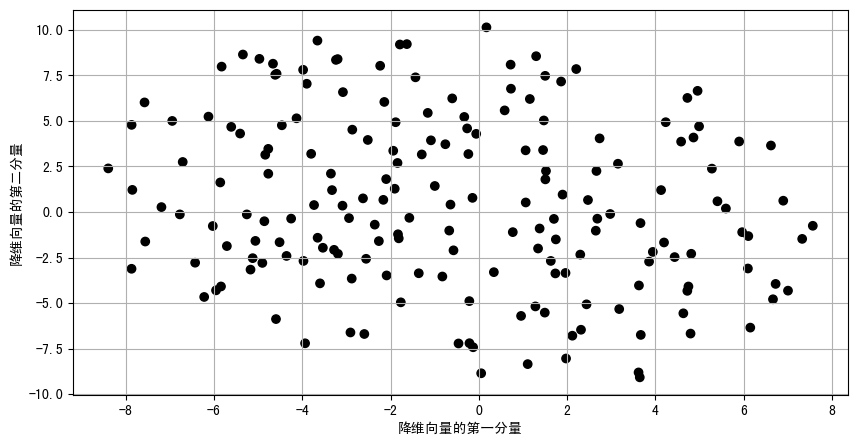

In [23]:
# 降维散点图
from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE

def scatter_dimension_reduced(start, end, state):
    temp = pd.merge(policy_and_states.groupby(['Year','Month'])['DocVec'].mean().reset_index(),
         states,
         left_on=['Year','Month'],
         right_on=['Year','Month']
        )
    temp = temp.loc[(temp['datetime64']>=start) & (temp['datetime64']<=end)]
#     display(temp)
    
    X_embedded = TSNE(n_components=2).fit_transform(np.array([i.tolist() for i in temp['DocVec'].values]))
    temp['TsneVec'] = [X_embedded[i] for i in range(len(X_embedded))]
    x = [i[0] for i in temp['TsneVec'].values]
    y = [i[1] for i in temp['TsneVec'].values]
    colors = temp[state].map({
        1:'#000000',
        2:'#000000'
    }).tolist()
    fig, ax = plt.subplots(figsize=(10,5))
    plt.scatter(x, y, c=colors)
    ax.set_xlabel('降维向量的第一分量')
    ax.set_ylabel('降维向量的第二分量')
#     ax.set_title('2维政策文本向量分布散点图')
    ax.grid(True)
    plt.show()

scatter_dimension_reduced(start='2007-12', end='2023-5',state='all')

### 回归

弱中强政策文本对于政策数量对（下一期）收益率波动性的影响具有调节效应，且调节效应随着情绪强度增加而明显 （分类回归得到）

In [464]:
temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
temp = pd.merge(temp, MacroIdx[['Year','Month','Bcidm0302']], right_on=['Year','Month'],left_on=['Year','Month'])
temp = pd.merge(temp, ISI[['Year','Month','StdExMacroISI']], right_on=['Year','Month'],left_on=['Year','Month'])

display(temp.head())
state = 'strong' # 状态
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    for quzhi in [1,2]:
        print('区制={}'.format(quzhi),end='\t')
        t = (temp[[ind, 'num',state, 'StdExMacroISI','Bcidm0302']]).copy()
        t[ind] = t[ind].shift(-1)
        t = t.loc[t[state]==quzhi]
        t.dropna(inplace=True)
        t = zscore(t)
        model = sm.OLS(
            t[[ind]],
            sm.add_constant(t[['num','StdExMacroISI','Bcidm0302']])
        ).fit()
#         print(model.summary2())
        print("{}: P-(num)={}".format(ind[0], round(model.params['num'],4)),end='')
        if model.pvalues['num']<0.01: print("***",end=' ')
        elif model.pvalues['num']>=0.01 and model.pvalues['num']<0.05: print("**",end=' ')
        elif model.pvalues['num']>=0.05 and model.pvalues['num']<0.1: print("*",end=' ')
        else: print('', end='')
        print('\t')
        
#         print("\t P-(cross)={}".format(round(model.pvalues[0],4)),end='')
#         if model.pvalues[0]<0.01: print("***")
#         elif model.pvalues[0]>=0.01 and model.pvalues[0]<0.05: print("**")
#         elif model.pvalues[0]>=0.05 and model.pvalues[0]<0.1: print("*")
#         else: print()
#     break

,datetime64,A_Var,B_Var,C_Var,D_Var,E_Var,F_Var,G_Var,H_Var,I_Var,...,R,S,all,weak,neutral,strong,concentration,num,Bcidm0302,StdExMacroISI
0,2005-03-31,0.000233,0.000162,0.000147,0.000135,0.000191,0.000152,0.000154,0.000210,0.000178,...,-0.1380,-0.1432,1.0,1.0,1.0,1.0,0.723415,106,0.087063,-1.66
1,2005-04-30,0.000406,0.000315,0.000296,0.000300,0.000374,0.000292,0.000208,0.000349,0.000437,...,-0.2547,-0.0908,1.0,1.0,1.0,1.0,0.728553,131,0.138850,-1.62
2,2005-05-31,0.000322,0.000195,0.000170,0.000124,0.000249,0.000185,0.000187,0.000203,0.000119,...,0.0376,-0.0265,1.0,1.0,1.0,1.0,0.756067,106,0.215405,-1.93
3,2005-06-30,0.000613,0.001005,0.000578,0.000644,0.000533,0.000484,0.000718,0.000582,0.000544,...,0.0172,-0.0175,1.0,1.0,1.0,1.0,0.770272,75,0.246928,-2.29
4,2005-07-31,0.000423,0.000381,0.000285,0.000226,0.000418,0.000249,0.000183,0.000407,0.000317,...,-0.1235,-0.0571,1.0,1.0,1.0,1.0,0.792813,89,0.296463,-2.20


区制=1	A: P-(num)=-0.1848* 	
区制=2	A: P-(num)=0.0765	
区制=1	B: P-(num)=-0.3789*** 	
区制=2	B: P-(num)=0.0809	
区制=1	C: P-(num)=-0.1424	
区制=2	C: P-(num)=0.0276	
区制=1	D: P-(num)=-0.2015** 	
区制=2	D: P-(num)=0.0644	
区制=1	E: P-(num)=-0.1297	
区制=2	E: P-(num)=0.0589	
区制=1	F: P-(num)=-0.1287	
区制=2	F: P-(num)=0.0345	
区制=1	G: P-(num)=-0.2114** 	
区制=2	G: P-(num)=0.0544	
区制=1	H: P-(num)=-0.2758*** 	
区制=2	H: P-(num)=-0.0345	
区制=1	I: P-(num)=-0.0631	
区制=2	I: P-(num)=0.0361	
区制=1	J: P-(num)=-0.3068*** 	
区制=2	J: P-(num)=0.0826	
区制=1	K: P-(num)=-0.2805*** 	
区制=2	K: P-(num)=0.0085	
区制=1	L: P-(num)=-0.2684*** 	
区制=2	L: P-(num)=0.0008	
区制=1	M: P-(num)=-0.0998	
区制=2	M: P-(num)=0.0111	
区制=1	N: P-(num)=-0.1366	
区制=2	N: P-(num)=0.012	
区制=1	O: P-(num)=-0.2524** 	
区制=2	O: P-(num)=-0.1746	
区制=1	P: P-(num)=0.1522	
区制=2	P: P-(num)=-0.0366	
区制=1	Q: P-(num)=-0.3407*** 	
区制=2	Q: P-(num)=0.0699	
区制=1	R: P-(num)=-0.1799* 	
区制=2	R: P-(num)=0.0266	
区制=1	S: P-(num)=-0.0786	
区制=2	S: P-(num)=0.0105	


In [462]:
temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
temp = pd.merge(temp, MacroIdx[['Year','Month','Bcidm0302']], right_on=['Year','Month'],left_on=['Year','Month'])
temp = pd.merge(temp, ISI[['Year','Month','StdExMacroISI']], right_on=['Year','Month'],left_on=['Year','Month'])

# display(temp.head())
state = 'neutral' # 状态
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    for quzhi in [1,2]:
        print('区制={}'.format(quzhi),end='\t')
        t = (temp[[ind, 'concentration',state, 'Bcidm0302','StdExMacroISI']]).copy()
        t[ind] = t[ind].shift(-1)
        t = t.loc[t[state]==quzhi]
        t.dropna(inplace=True)
        t = zscore(t)
        model = sm.OLS(
            t[[ind]],
            sm.add_constant(t[['concentration','Bcidm0302','StdExMacroISI']])
        ).fit()
#         print(model.summary2())
        print("{}: P-(concentration)={}".format(ind[0], round(model.params['concentration'],4)),end='')
        if model.pvalues['concentration']<0.01: print("***",end=' ')
        elif model.pvalues['concentration']>=0.01 and model.pvalues['concentration']<0.05: print("**",end=' ')
        elif model.pvalues['concentration']>=0.05 and model.pvalues['concentration']<0.1: print("*",end=' ')
        else: print('', end='')
        print('\t')

区制=1	A: P-(concentration)=0.2157** 	
区制=2	A: P-(concentration)=-0.0599	
区制=1	B: P-(concentration)=0.321*** 	
区制=2	B: P-(concentration)=0.0652	
区制=1	C: P-(concentration)=0.2369*** 	
区制=2	C: P-(concentration)=0.0088	
区制=1	D: P-(concentration)=0.1975** 	
区制=2	D: P-(concentration)=-0.0005	
区制=1	E: P-(concentration)=0.1447* 	
区制=2	E: P-(concentration)=0.0128	
区制=1	F: P-(concentration)=0.2237*** 	
区制=2	F: P-(concentration)=0.016	
区制=1	G: P-(concentration)=0.2276*** 	
区制=2	G: P-(concentration)=0.0088	
区制=1	H: P-(concentration)=0.2364*** 	
区制=2	H: P-(concentration)=0.0743	
区制=1	I: P-(concentration)=0.1136	
区制=2	I: P-(concentration)=0.0554	
区制=1	J: P-(concentration)=0.1887** 	
区制=2	J: P-(concentration)=0.002	
区制=1	K: P-(concentration)=0.2503*** 	
区制=2	K: P-(concentration)=0.0276	
区制=1	L: P-(concentration)=0.2304*** 	
区制=2	L: P-(concentration)=-0.0024	
区制=1	M: P-(concentration)=0.0416	
区制=2	M: P-(concentration)=0.0016	
区制=1	N: P-(concentration)=0.1592* 	
区制=2	N: P-(concentration)=-0.0029	
区制=1	O

## 投资者情绪与市场状态

In [488]:
ISI = (pd.read_csv('/Users/yanyan/Documents/MyQuant/研究——前景因子的构建/Data/ISI综合情绪指数表/QX_ISI.csv')
         .assign(datetimeNP=lambda x: x[['SgnMonth']].applymap(lambda x: np.datetime64(x)))
         .assign(Year = lambda x: x[['datetimeNP']].applymap(lambda y: y.year))
         .assign(Month = lambda x: x[['datetimeNP']].applymap(lambda y: y.month))
         .pipe(lambda x: pd.merge(x, states, right_on=['Year','Month'], left_on=['Year','Month']))
        )

display(ISI.head())

,SgnMonth,StdExMacroISI,datetimeNP,Year,Month,datetime64,all,weak,neutral,strong
0,2005-03,-1.66,2005-03-01,2005,3,2005-03-31,1.0,1.0,1.0,1.0
1,2005-04,-1.62,2005-04-01,2005,4,2005-04-30,1.0,1.0,1.0,1.0
2,2005-05,-1.93,2005-05-01,2005,5,2005-05-31,1.0,1.0,1.0,1.0
3,2005-06,-2.29,2005-06-01,2005,6,2005-06-30,1.0,1.0,1.0,1.0
4,2005-07,-2.20,2005-07-01,2005,7,2005-07-31,1.0,1.0,1.0,1.0


<Axes: >

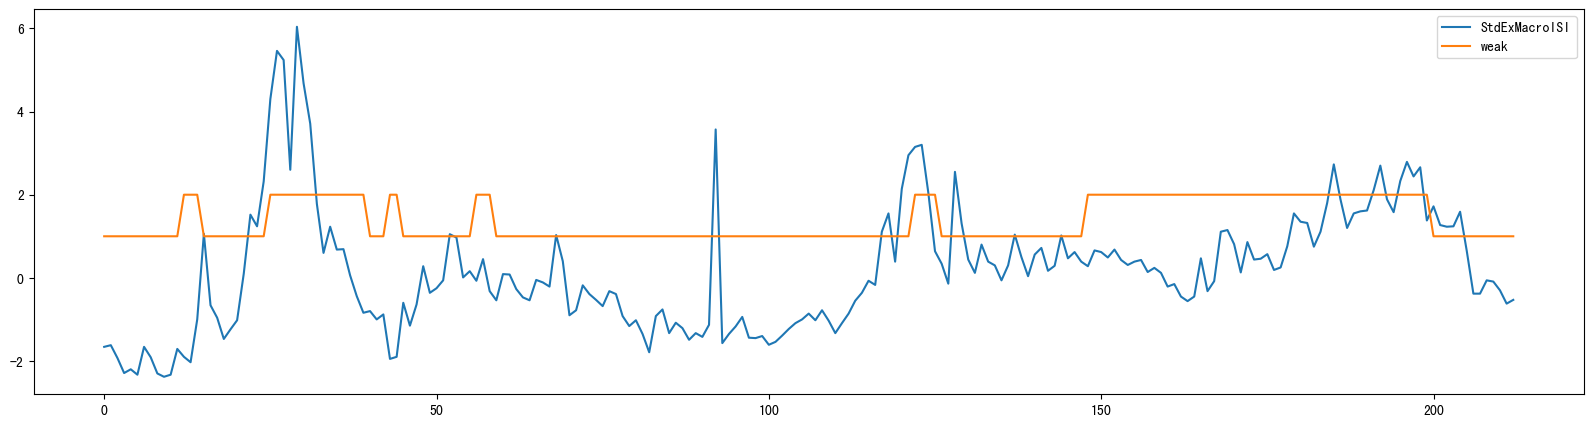

In [489]:
ISI[['StdExMacroISI','weak']].plot(figsize=(20,5))

In [546]:
temp = pd.merge(index_000001_ret_and_pricing, ISI[['Year','Month','StdExMacroISI']], right_on=['Year','Month'], left_on=['Year','Month'])
# temp = pd.merge(index_000001,temp, right_on=['Year','Month'], left_on=['Year','Month'])
# display(temp.head())

state = 'weak' # 状态
for quzhi in [0,1]:
    t = temp.loc[temp[state]==quzhi]
    model = sm.OLS(
        t['Return_next'],
        sm.add_constant(pd.concat([
            t['StdExMacroISI']
        ],axis=1))  
    ).fit() # cov_kwds={'maxlags':3}, cov_type='HAC'
    print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.001   
Dependent Variable: Return_next      AIC:                -320.2618
Date:               2024-03-30 19:24 BIC:                -314.4661
No. Observations:   134              Log-Likelihood:     162.13   
Df Model:           1                F-statistic:        0.8343   
Df Residuals:       132              Prob (F-statistic): 0.363    
R-squared:          0.006            Scale:              0.0052859
-------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|    [0.025  0.975]
-------------------------------------------------------------------
const             0.0078    0.0065  1.1929  0.2351  -0.0051  0.0208
StdExMacroISI     0.0051    0.0056  0.9134  0.3627  -0.0059  0.0161
------------------------------------------------------------------
Omnibus:              9.895        Durbin-Watson:           1.809 
Prob(Omn

## 市场状态与宏观经济景气指数

In [396]:
MacroIdx = (pd.read_csv('/Users/yanyan/Documents/MyQuant/研究——前景因子的构建/Data/宏观经济景气指数月度文件/CME_Mbcid3.csv')
         .assign(datetimeNP=lambda x: x[['Staper']].applymap(lambda x: np.datetime64(x)))
         .assign(Year = lambda x: x[['datetimeNP']].applymap(lambda y: y.year))
         .assign(Month = lambda x: x[['datetimeNP']].applymap(lambda y: y.month))
         .pipe(lambda x: pd.merge(x, states, right_on=['Year','Month'], left_on=['Year','Month']))
         .assign(Bcidm0302 = zscore(MacroIdx['Bcidm0302']))
        )
MacroIdx.head()

,Staper,Bcidm0302,datetimeNP,Year,Month,datetime64,all,weak,neutral,strong
0,2005-03,0.087063,2005-03-01,2005,3,2005-03-31,1.0,1.0,1.0,1.0
1,2005-04,0.138850,2005-04-01,2005,4,2005-04-30,1.0,1.0,1.0,1.0
2,2005-05,0.215405,2005-05-01,2005,5,2005-05-31,1.0,1.0,1.0,1.0
3,2005-06,0.246928,2005-06-01,2005,6,2005-06-30,1.0,1.0,1.0,1.0
4,2005-07,0.296463,2005-07-01,2005,7,2005-07-31,1.0,1.0,1.0,1.0


<Axes: >

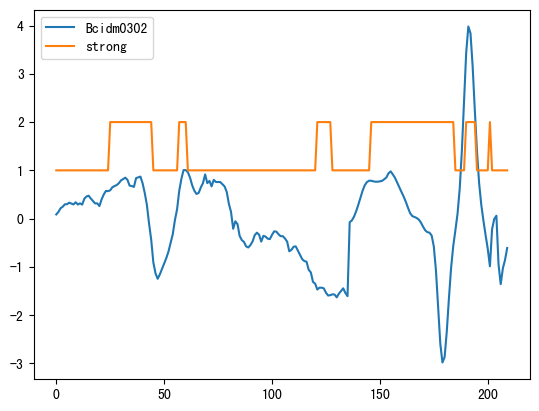

In [397]:
MacroIdx[['Bcidm0302','strong']].plot()

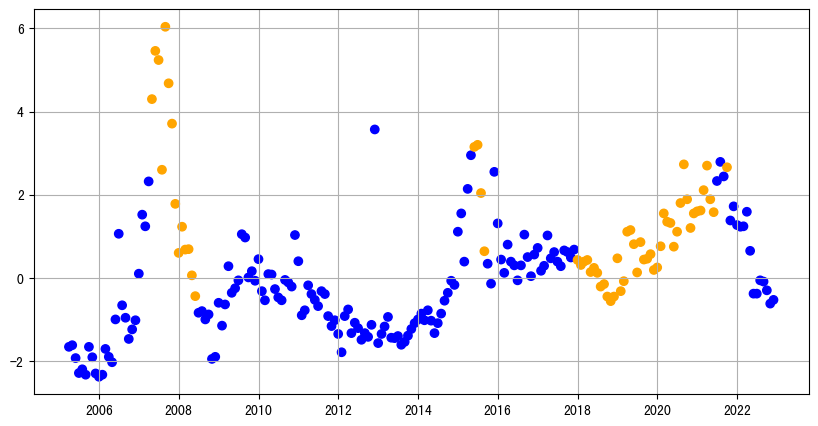

In [355]:
state = 'neutral'
colors = CICSI[state].map({
        1:'blue',
        2:'orange'
    }).tolist()
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(CICSI['datetime64'], CICSI['StdExMacroISI'], c=colors)
# ax.set_xlabel('降维向量的第一分量')
# ax.set_ylabel('降维向量的第二分量')
plt.grid(True)
#     plt.title('降维政策文本向量散点图 \n({})'.format(labels[state]))
plt.show()

# 中国政策不确定性对行业波动性的影响

In [516]:
EPU = (pd.read_excel('/Users/yanyan/Downloads/China_Mainland_Paper_EPU.xlsx',sheet_name='EPU 2000 onwards')
       .assign(Year=lambda x: x['year'])
       .assign(Month=lambda x: x['month'])
       .pipe(lambda x: x[['Year','Month','EPU']])
      )



检验政策不确定性是否对收益率波动性有显著影响
A: P-(EPU)=3.4103***
B: P-(EPU)=0.0002***
C: P-(EPU)=0.012***
D: P-(EPU)=0.0001***
E: P-(EPU)=0.0003***
F: P-(EPU)=0.0046***
G: P-(EPU)=0.0004***
H: P-(EPU)=43.5663**
I: P-(EPU)=0.3048***
J: P-(EPU)=0.0005***
K: P-(EPU)=0.0001***
L: P-(EPU)=0.1632***
M: P-(EPU)=0.0211***
N: P-(EPU)=0.0017***
O: P-(EPU)=847.2213
P: P-(EPU)=0.0101***
Q: P-(EPU)=0.003***
R: P-(EPU)=0.0***
S: P-(EPU)=0.2196***


In [539]:
temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
temp = pd.merge(temp, MacroIdx[['Year','Month','Bcidm0302']], right_on=['Year','Month'],left_on=['Year','Month'])
temp = pd.merge(temp, ISI[['Year','Month','StdExMacroISI']], right_on=['Year','Month'],left_on=['Year','Month'])
temp = pd.merge(temp, EPU, right_on=['Year','Month'],left_on=['Year','Month'],how='left')

# display(temp.head())
state = 'strong' # 状态
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    for quzhi in [1,2]:
        print('区制={}'.format(quzhi),end='\t')
        t = (temp[[ind, 'concentration',state, 'Bcidm0302','StdExMacroISI','EPU']]).copy()
        t[ind] = t[ind].shift(-1)
        t = t.loc[t[state]==quzhi]
        t.dropna(inplace=True)
        t = zscore(t)
        model = sm.OLS(
            t[[ind]],
            sm.add_constant(
                pd.concat([
                    t[['EPU','StdExMacroISI','Bcidm0302']],
                ],axis=1)
            )
        ).fit()
#         print(model.summary2())
        print("{}: P-(EPU)={}".format(ind[0], round(model.params['EPU'],4)),end='')
        if model.pvalues['EPU']<0.01: print("***",end=' ')
        elif model.pvalues['EPU']>=0.01 and model.pvalues['EPU']<0.05: print("**",end=' ')
        elif model.pvalues['EPU']>=0.05 and model.pvalues['EPU']<0.1: print("*",end=' ')
        else: print('', end='')
        print('\t')

区制=1	A: P-(EPU)=-0.1219	
区制=2	A: P-(EPU)=-0.4073*** 	
区制=1	B: P-(EPU)=-0.2729*** 	
区制=2	B: P-(EPU)=-0.5497*** 	
区制=1	C: P-(EPU)=-0.271*** 	
区制=2	C: P-(EPU)=-0.4704*** 	
区制=1	D: P-(EPU)=-0.3138*** 	
区制=2	D: P-(EPU)=-0.4852*** 	
区制=1	E: P-(EPU)=-0.3433*** 	
区制=2	E: P-(EPU)=-0.4561*** 	
区制=1	F: P-(EPU)=-0.2918*** 	
区制=2	F: P-(EPU)=-0.4453*** 	
区制=1	G: P-(EPU)=-0.3196*** 	
区制=2	G: P-(EPU)=-0.4716*** 	
区制=1	H: P-(EPU)=0.0237	
区制=2	H: P-(EPU)=-0.3992*** 	
区制=1	I: P-(EPU)=-0.2358** 	
区制=2	I: P-(EPU)=-0.4271*** 	
区制=1	J: P-(EPU)=-0.4125*** 	
区制=2	J: P-(EPU)=-0.5568*** 	
区制=1	K: P-(EPU)=-0.3324*** 	
区制=2	K: P-(EPU)=-0.5679*** 	
区制=1	L: P-(EPU)=-0.2211** 	
区制=2	L: P-(EPU)=-0.4431*** 	
区制=1	M: P-(EPU)=-0.2473** 	
区制=2	M: P-(EPU)=-0.4582*** 	
区制=1	N: P-(EPU)=-0.2733*** 	
区制=2	N: P-(EPU)=-0.4948*** 	
区制=1	O: P-(EPU)=0.0002	
区制=2	O: P-(EPU)=-0.3072** 	
区制=1	P: P-(EPU)=-0.2152	
区制=2	P: P-(EPU)=-0.3699*** 	
区制=1	Q: P-(EPU)=-0.2477** 	
区制=2	Q: P-(EPU)=-0.4328*** 	
区制=1	R: P-(EPU)=-0.3462*** 	
区制=2	R: P

In [329]:
# temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
#         .pipe(lambda x: pd.merge(x,
#                                 pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
#                                     left_on='datetime64',right_on='datetime64'
#                                 ))
#        )
# # display(temp.head())
# print('检验政策数量是否对收益率波动性有显著影响(无收益率滞后项)')
# for ind in ['A_Var',
#        'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
#        'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
#        'R_Var', 'S_Var']:
#     t = (temp[[ind, 'num']]).copy()
#     t[ind] = t[ind].shift(-1)
#     t.dropna(inplace=True)
#     model = sm.OLS(
#         t[[ind]],
#         sm.add_constant(t[['num']])
#     ).fit()
#     print("{}:\t P-(num)={}".format(ind[0], model.pvalues['num']),end='')
#     if model.pvalues['num']<0.01: print("***")
#     elif model.pvalues['num']>=0.01 and model.pvalues['num']<0.05: print("**")
#     elif model.pvalues['num']>=0.05 and model.pvalues['num']<0.1: print("*")
#     else: print()
    
# print('\n\n检验政策相关性是否对收益率波动性有显著影响(无收益率滞后项)')
# for ind in ['A_Var',
#        'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
#        'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
#        'R_Var', 'S_Var']:
#     t = (temp[[ind, 'concentration']]).copy()
#     t[ind] = t[ind].shift(-1)
#     t.dropna(inplace=True)
#     model = sm.OLS(
#         t[[ind]],
#         sm.add_constant(t[['concentration']])
#     ).fit()
#     print("{}:\t P-(concentration)={}".format(ind[0], model.pvalues['concentration']), end='')
#     if model.pvalues['concentration']<0.01: print("***")
#     elif model.pvalues['concentration']>=0.01 and model.pvalues['concentration']<0.05: print("**")
#     elif model.pvalues['concentration']>=0.05 and model.pvalues['concentration']<0.1: print("*")
#     else: print()

In [330]:
# temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
#         .pipe(lambda x: pd.merge(x,
#                                 pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
#                                     left_on='datetime64',right_on='datetime64'
#                                 ))
#        )
# # display(temp.head())
# print('检验政策数量是否对收益率波动性有显著影响（有收益率滞后项）')
# for ind in ['A_Var',
#        'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
#        'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
#        'R_Var', 'S_Var']:
#     t = (temp[[ind, 'num']]).copy()
#     t.dropna(inplace=True)
#     model = sm.OLS(
#         t[[ind]][1:],
#         pd.concat([sm.add_constant(t[['num']]), t[[ind]].shift(1)],axis=1)[1:]
#     ).fit()
#     print("{}:\t P-(num)={}".format(ind[0], model.pvalues['num']),end='')
#     if model.pvalues['num']<0.01: print("***")
#     elif model.pvalues['num']>=0.01 and model.pvalues['num']<0.05: print("**")
#     elif model.pvalues['num']>=0.05 and model.pvalues['num']<0.1: print("*")
#     else: print()
    
# print('\n\n检验政策相关性是否对收益率波动性有显著影响（有收益率滞后项）')
# for ind in ['A_Var',
#        'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
#        'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
#        'R_Var', 'S_Var']:
#     t = (temp[[ind, 'concentration']]).copy()
#     t.dropna(inplace=True)
#     model = sm.OLS(
#         t[[ind]][1:],
#         pd.concat([sm.add_constant(t[['concentration']]), t[[ind]].shift(1)],axis=1)[1:]
#     ).fit()
#     print("{}:\t P-(concentration)={}".format(ind[0], model.pvalues['concentration']), end='')
#     if model.pvalues['concentration']<0.01: print("***")
#     elif model.pvalues['concentration']>=0.01 and model.pvalues['concentration']<0.05: print("**")
#     elif model.pvalues['concentration']>=0.05 and model.pvalues['concentration']<0.1: print("*")
#     else: print()

检验政策相关性是否对收益率波动性有显著影响


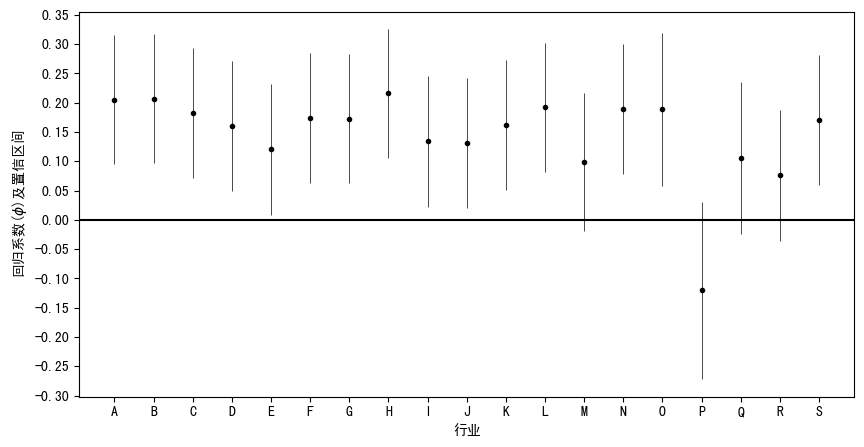

In [87]:
from scipy.stats import zscore

alpha = 0.1

temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )


print('检验政策相关性是否对收益率波动性有显著影响')
fig, ax = plt.subplots(figsize=(10,5))

for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'concentration']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        zscore(t[[ind]]),
        sm.add_constant(zscore(t[['concentration']]))
    ).fit()
#     print(model.summary())
    y_error = model.conf_int(alpha).loc['concentration',:].values.reshape((2,1))[1][0]\
                - model.params['concentration']
    ax.errorbar(ind[0],
                model.params['concentration'],
                yerr=y_error,
                fmt='o',
                markersize=3.,
                color='black',
                lw=0.5
               )
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
# plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_xlabel('行业')
ax.set_ylabel('回归系数($\phi$)及置信区间')
# ax.set_title('收益率波动性对政策相关性回归结果\n '+r'$\alpha={}$'.format(alpha))
ax.axhline(0,color='black')
plt.show()

检验政策数量是否对收益率波动性有显著影响


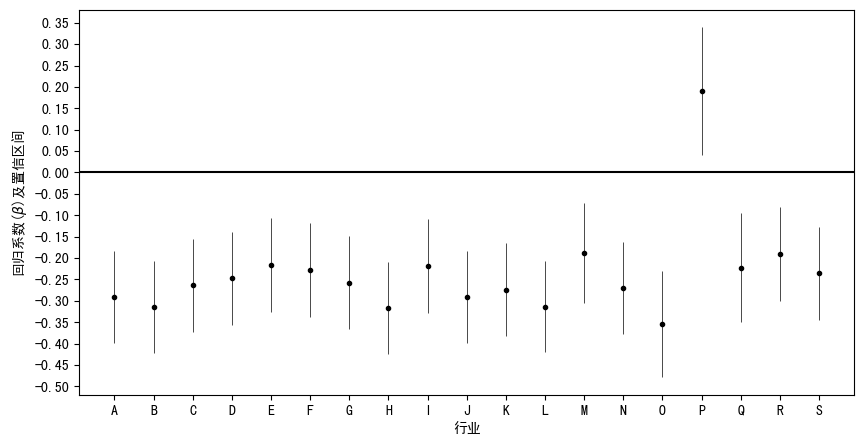

In [88]:
from scipy.stats import zscore

alpha = 0.1

temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
# display(temp.head())
print('检验政策数量是否对收益率波动性有显著影响')

fig, ax = plt.subplots(figsize=(10,5))
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'num']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        zscore(t[[ind]]),
        sm.add_constant(zscore(t[['num']]))
    ).fit()
    y_error = model.conf_int(alpha).loc['num',:].values.reshape((2,1))[1][0]\
                - model.params['num']
    ax.errorbar(ind[0],
                model.params['num'],
                yerr=y_error,
                fmt='o',
                markersize=3.,
                color='black',
                lw=0.5
               )
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
# plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_xlabel('行业')
ax.set_ylabel(r'回归系数($\beta$)及置信区间')
# ax.set_title('收益率波动性对政策数量回归结果\n '+r'$\alpha={}$'.format(alpha))
ax.axhline(0,color='black')
plt.show()

# 收益率分解视角

In [477]:
index_assetpricing = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数估值指标.csv',usecols=[0,1,2,3])
                      .assign(datetime64=lambda x: x[['交易日_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                     )
print(len(index_assetpricing))
print((index_assetpricing['IndexCode']).unique())
# index_assetpricing.head()
index_000001 = index_assetpricing.loc[index_assetpricing['IndexCode']=='000001'][['Year','Month','滚动市盈率_PE_TTM','滚动股息率(%)_DYR_TTM']].groupby(['Year','Month']).mean()
index_000001.reset_index(inplace=True)
# index_000001['PE_t-1'] = index_000001['滚动市盈率_PE_TTM'].shift()
# index_000001['DP_t-1'] = index_000001['滚动股息率(%)_DYR_TTM'].shift()
# index_000001.dropna(inplace=True)
index_000001.head()

63071
['000001' '000004' '000006' '000008' '000005' '000016' '000007' '000903'
 '000906' '000852' '000904' '000907' '000905']


,Year,Month,滚动市盈率_PE_TTM,滚动股息率(%)_DYR_TTM
0,2000,1,50.365468,1.317358
1,2000,2,56.330283,1.122500
2,2000,3,56.862013,1.080826
3,2000,4,59.749025,1.033535
4,2000,5,57.622950,1.106844


In [478]:
index_ret_000001 = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数收益率(000001).csv')
                      .assign(datetime64=lambda x: x[['交易日期_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                      .pipe(lambda x: x[['Year','Month','收盘价(元/点)_ClPr']].groupby(['Year','Month']).apply(lambda x: x.iloc[-1]/x.iloc[0]-1)['收盘价(元/点)_ClPr'])
                      .pipe(lambda x: pd.DataFrame(x))
                      .rename(columns={'收盘价(元/点)_ClPr':'Return'})
#                       .assign(Return_next = lambda x: x['Return'].shift(-1))
#                       .dropna()
                   )

index_000001_ret_and_pricing = pd.merge(index_000001, index_ret_000001, left_on=['Year','Month'], right_index=True)
index_000001_ret_and_pricing = pd.merge(states, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
index_000001_ret_and_pricing = (
    index_000001_ret_and_pricing
    .assign(weak = lambda x: x['weak']-1)
    .assign(neutral = lambda x: x['neutral']-1)
    .assign(strong = lambda x: x['strong']-1)
#     .assign(InfoLevel4 = lambda x: x['InfoLevel4']-1)
)
index_000001_ret_and_pricing['all']=index_000001_ret_and_pricing['all']-1



riskfree_ret = (
    evaluator.Return[['月无风险收益率_Monrfret','datetime64']].drop_duplicates().ffill()
    .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
    .pipe(lambda x: x[['月无风险收益率_Monrfret','Year','Month']])
    .pipe(lambda x: x.groupby(['Year','Month'])['月无风险收益率_Monrfret'].last().reset_index())
)

index_000001_ret_and_pricing = (pd.merge(riskfree_ret, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
                                .assign(Return = lambda x: x['Return']-x['月无风险收益率_Monrfret'])
                                .assign(Return_next = lambda x: x[['Return']].shift(-1))
                                .pipe(lambda x: x.loc[x['Return']!=x['Return_next']])
                                .dropna()
                               )
display(index_000001_ret_and_pricing)

,Year,Month,月无风险收益率_Monrfret,datetime64,all,weak,neutral,strong,滚动市盈率_PE_TTM,滚动股息率(%)_DYR_TTM,Return,Return_next
0,2005,3,0.001454,2005-03-31,0.0,0.0,0.0,0.0,20.353817,3.777074,-0.095190,-0.053603
1,2005,4,0.000954,2005-04-30,0.0,0.0,0.0,0.0,19.153081,3.806943,-0.053603,-0.062954
2,2005,5,0.000967,2005-05-31,0.0,0.0,0.0,0.0,18.000500,4.481788,-0.062954,0.039237
3,2005,6,0.000940,2005-06-30,0.0,0.0,0.0,0.0,17.660591,5.328909,0.039237,0.025042
4,2005,7,0.000952,2005-07-31,0.0,0.0,0.0,0.0,16.892386,6.200290,0.025042,0.066923
...,...,...,...,...,...,...,...,...,...,...,...,...
213,2022,12,0.001931,2022-12-31,0.0,0.0,0.0,0.0,12.510277,2.647336,-0.026007,0.042679
214,2023,1,0.001973,2023-01-31,0.0,0.0,0.0,0.0,12.854606,2.664456,0.042679,-0.003604
215,2023,2,0.001986,2023-02-28,0.0,0.0,0.0,0.0,13.217595,2.587695,-0.003604,-0.013963
216,2023,3,0.002042,2023-03-31,0.0,0.0,0.0,0.0,13.378596,2.583009,-0.013963,0.006133


$$R_{t+1} = \alpha S_t \times D/P_{t} + \beta D/P_{t} + \gamma S_t + C + \epsilon_t,\quad $$

In [479]:
def pvalue2stars(x):
    if x<0.01:
        return '***'
    elif x<0.05:
        return "**"
    elif x<0.1:
        return "*"
    else:
        return ''

res={
    '$\alpha$':[],
    'alpha t-value':[],
    '$\beta$':[],
    'beta t-value':[],
    '$\gamma$':[],
    'gamma t-value':[],
    'const':[],
    'const_t-value':[],
    '$Adj.R^2$':[]
}

for state in ['all','weak','neutral','strong']:
#     for quzhi in [0,1]:
    t = index_000001_ret_and_pricing
#         t = index_000001_ret_and_pricing.loc[index_000001_ret_and_pricing[state]==quzhi].dropna()
    model = sm.OLS(t['Return_next'],
               sm.add_constant(pd.concat([
                   t[state]*t['滚动股息率(%)_DYR_TTM'],
                   t[['滚动股息率(%)_DYR_TTM']],
                   t[state]
               ],axis=1))
              ).fit()
#     print(model.summary2(),end='\n')
    res['$\alpha$'].append((model.params[0]*100).round(2))
    res['alpha t-value'].append("{}{}".format(model.tvalues[0].round(2), pvalue2stars(model.pvalues[0])))

    res['$\beta$'].append((model.params['滚动股息率(%)_DYR_TTM']*100).round(2))
    res['beta t-value'].append("{}{}".format(model.tvalues['滚动股息率(%)_DYR_TTM'].round(2), pvalue2stars(model.pvalues['滚动股息率(%)_DYR_TTM'])))
    
    res['$\gamma$'].append((model.params[state]*100).round(2))
    res['gamma t-value'].append("{}{}".format(model.tvalues[state].round(2), pvalue2stars(model.pvalues[state])))

    res['const'].append((model.params['const']*100).round(2))
    res['const_t-value'].append("{}{}".format(model.tvalues['const'].round(2), pvalue2stars(model.pvalues['const'])))
    
    res['$Adj.R^2$'].append((model.rsquared_adj*100).round(2))

print(pd.DataFrame(res, index=['all','weak','neutral','strong']).to_latex())

\begin{tabular}{lrlrlrlrlr}
\toprule
{} &  \$lpha\$ & alpha t-value &  \$eta\$ & beta t-value &  \$\textbackslash gamma\$ & gamma t-value &  const & const\_t-value &  \$Adj.R\textasciicircum 2\$ \\
\midrule
all     &     1.31 &           0.9 &    0.17 &         0.27 &     -3.91 &         -1.34 &   0.15 &           0.1 &       0.17 \\
weak    &     1.94 &          1.48 &   -0.07 &        -0.11 &     -4.73 &        -1.74* &   0.75 &          0.47 &       0.52 \\
neutral &     1.42 &          1.04 &    0.06 &         0.09 &     -4.20 &         -1.51 &   0.49 &          0.33 &       0.46 \\
strong  &     1.88 &          1.39 &   -0.24 &        -0.36 &     -5.51 &       -2.02** &   1.44 &          0.89 &       1.61 \\
\bottomrule
\end{tabular}



/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_77450/3219503511.py:49: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res, index=['all','weak','neutral','strong']).to_latex())


In [480]:
res={
    '$\alpha$':[],
    'alpha t-value':[],
    '$\beta$':[],
    'beta t-value':[],
    '$\gamma$':[],
    'gamma t-value':[],
    'const':[],
    'const_t-value':[],
    '$Adj.R^2$':[]
}

for state in ['all','weak','neutral','strong']:
    model = sm.OLS(index_000001_ret_and_pricing['Return_next'],
               sm.add_constant(pd.concat([
                   (index_000001_ret_and_pricing[state])*index_000001_ret_and_pricing['滚动市盈率_PE_TTM'],
                   index_000001_ret_and_pricing[['滚动市盈率_PE_TTM']],
                   index_000001_ret_and_pricing[[state]]
               ],axis=1))
              ).fit()
    res['$\alpha$'].append((model.params[0]*100).round(2))
    res['alpha t-value'].append("{}{}".format(model.tvalues[0].round(2), pvalue2stars(model.pvalues[0])))

    res['$\beta$'].append((model.params['滚动市盈率_PE_TTM']*100).round(2))
    res['beta t-value'].append("{}{}".format(model.tvalues['滚动市盈率_PE_TTM'].round(2), pvalue2stars(model.pvalues['滚动市盈率_PE_TTM'])))
    
    res['$\gamma$'].append((model.params[state]*100).round(2))
    res['gamma t-value'].append("{}{}".format(model.tvalues[state].round(2), pvalue2stars(model.pvalues[state])))

    res['const'].append((model.params['const']*100).round(2))
    res['const_t-value'].append("{}{}".format(model.tvalues['const'].round(2), pvalue2stars(model.pvalues['const'])))
    
    res['$Adj.R^2$'].append((model.rsquared_adj*100).round(2))

print(pd.DataFrame(res, index=['all','weak','neutral','strong']).to_latex())

\begin{tabular}{lrlrlrlrlr}
\toprule
{} &  \$lpha\$ & alpha t-value &  \$eta\$ & beta t-value &  \$\textbackslash gamma\$ & gamma t-value &  const & const\_t-value &  \$Adj.R\textasciicircum 2\$ \\
\midrule
all     &    -0.12 &         -1.08 &    0.11 &         1.32 &      0.45 &          0.18 &  -1.31 &         -0.88 &       0.39 \\
weak    &    -0.19 &         -1.62 &    0.17 &        1.77* &      2.04 &          0.86 &  -2.19 &          -1.3 &       0.76 \\
neutral &    -0.17 &         -1.47 &    0.15 &        1.68* &      1.20 &           0.5 &  -1.90 &         -1.18 &       1.11 \\
strong  &    -0.25 &       -2.12** &    0.22 &       2.33** &      2.04 &          0.87 &  -2.69 &         -1.63 &       3.21 \\
\bottomrule
\end{tabular}



/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_77450/3821132096.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res, index=['all','weak','neutral','strong']).to_latex())


## ADF检验

In [119]:
for j in range(1,4):
    data = pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/时间序列向量导出结果/DocVec_monthly_InfoLevel{}_20240207_cutted.csv'.format(j))
    for i in range(10):
        print(sm.tsa.stattools.adfuller(data[str(i)])[1]<0.01)

True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False


# 不同区制的政策文本之间的区别

In [417]:
from scipy.stats import ks_2samp
cat = ['weak','neutral','strong']
for policy_cat in cat:
    print(policy_cat, end=':\t')
    print(ks_2samp(
                    concentration.loc[concentration[policy_cat]==1]['concentration'].values,
                    concentration.loc[concentration[policy_cat]==2]['concentration'].values,
                  ).statistic
         )

weak:	0.4652014652014652
neutral:	0.5681434599156118
strong:	0.40923076923076923


In [416]:
for i in cat:
    display(concentration.groupby(i)['concentration'].apply(lambda x: np.quantile(x,0.99)))
#     print('mean')
#     display(concentration.groupby(i)['concentration'].mean())
#     print('std')
#     display(concentration.groupby(i)['concentration'].std())

weak
1.0    0.808586
2.0    0.959277
Name: concentration, dtype: float64

neutral
1.0    0.814444
2.0    0.968796
Name: concentration, dtype: float64

strong
1.0    0.815097
2.0    0.960863
Name: concentration, dtype: float64

In [410]:
min(concentration.loc[(concentration[policy_cat]==1)\
                      & (concentration[policy_cat]==1)
                     ]['concentration'].values)

0.6982128050185277

# 政策语意对于市场收益率标准差的影响

In [251]:
# 000001 上证综指 000002 A股指数
Idx_daily = (pd.read_csv('/Users/yanyan/Downloads/RESSET_IDXQTTN_1(上证综指和A股指数).csv')
        .assign(datetime64 = lambda x: x[['交易日期_TrdDt']].applymap(lambda x: np.datetime64(x)))
        .pipe(lambda x: x.loc[x['指数代码_IdxCd']==2])
        .assign(Month = lambda x: x[['datetime64']].applymap(lambda x: x.month))
        .assign(Year = lambda x: x[['datetime64']].applymap(lambda x: x.year))
       )
# display(SZZZ_daily.head())

In [252]:
temp = (pd.merge(
                SZZZ_daily.groupby(['Year','Month'])['涨跌幅(%)_ChgPct'].std().shift(-1).reset_index(),
                concentration,
                right_on=['Year','Month'],
                left_on=['Year','Month'],
                )
        .rename(columns={'涨跌幅(%)_ChgPct':'Idx_var'})
        .assign(Idx_var_next = lambda x: x['Idx_var'].shift(-1))
       ).dropna()

cat = 'neutral'
model = sm.OLS(temp['Idx_var_next'],
               sm.add_constant(pd.concat([
                   temp[cat]-1,
                   temp['concentration'],
                   (temp[cat]-1)*temp['concentration']
               ],axis=1))
              ).fit()
print(model.summary2())

                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.052  
Dependent Variable: Idx_var_next     AIC:                66.2976
Date:               2024-03-29 16:20 BIC:                74.8061
No. Observations:   62               Log-Likelihood:     -29.149
Df Model:           3                F-statistic:        2.123  
Df Residuals:       58               Prob (F-statistic): 0.107  
R-squared:          0.099            Scale:              0.16027
----------------------------------------------------------------
                  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------
const            -0.1382   3.4853 -0.0396 0.9685 -7.1147  6.8384
neutral          -0.9342   3.7055 -0.2521 0.8018 -8.3515  6.4832
concentration     1.4218   4.6589  0.3052 0.7613 -7.9040 10.7475
0                 1.3551   4.9242  0.2752 0.7841 -8.5017 11.2119
------------------------------------------

In [254]:
states

,datetime64,all,weak,neutral,strong,Year,Month
0,2005-03-31,1.0,1.0,1.0,1.0,2005,3
1,2005-04-30,1.0,1.0,1.0,1.0,2005,4
2,2005-05-31,1.0,1.0,1.0,1.0,2005,5
3,2005-06-30,1.0,1.0,1.0,1.0,2005,6
4,2005-07-31,1.0,1.0,1.0,1.0,2005,7
...,...,...,...,...,...,...,...
214,2023-01-31,1.0,1.0,1.0,1.0,2023,1
215,2023-02-28,1.0,1.0,1.0,1.0,2023,2
216,2023-03-31,1.0,1.0,1.0,1.0,2023,3
217,2023-04-30,1.0,1.0,1.0,1.0,2023,4


In [256]:
index_ret_000001 = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数收益率(000001).csv')
                      .assign(datetime64=lambda x: x[['交易日期_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                      .pipe(lambda x: x[['Year','Month','收盘价(元/点)_ClPr']].groupby(['Year','Month']).apply(lambda x: x.iloc[-1]/x.iloc[0]-1)['收盘价(元/点)_ClPr'])
                      .pipe(lambda x: pd.DataFrame(x))
                      .rename(columns={'收盘价(元/点)_ClPr':'Return'})
#                       .assign(Return_next = lambda x: x['Return'].shift(-1))
#                       .dropna()
                   )
index_000001

,Year,Month,滚动市盈率_PE_TTM,滚动股息率(%)_DYR_TTM
0,2007,1,53.810177,0.713562
1,2007,2,56.428487,0.646607
2,2007,3,62.341268,0.531382
3,2007,4,69.354281,0.426705
4,2007,5,82.519839,0.367878
...,...,...,...,...
200,2023,9,23.608215,1.770140
201,2023,10,22.659700,1.852159
202,2023,11,22.574427,1.837564
203,2023,12,21.947086,1.857824
